In [1]:
import math, random
from typing import NamedTuple, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load customers
customers = pd.read_csv("/Users/mithi/Downloads/customers.csv")
customers.head()

,id,x,y
0,1,63.942680,2.501076
1,2,27.502932,22.321074
2,3,73.647121,67.669949
3,4,89.217957,8.693883
4,5,42.192182,2.979722


In [4]:
# Depot & customer coordinates
depot = (customers["x"].mean(), customers["y"].mean())
customer_coords = list(zip(customers["x"], customers["y"]))
N = len(customer_coords)  
V = 5  

print("Depot:", depot)
print("Number of customers:", N)
print("First 5 customer coordinates:", customer_coords[:5])

Depot: (52.27493489624376, 43.63891372903963)
Number of customers: 50
First 5 customer coordinates: [(63.942679845788376, 2.5010755222666936), (27.502931836911927, 22.32107381488228), (73.64712141640123, 67.66994874229113), (89.21795677048453, 8.693883262941615), (42.192181968527045, 2.9797219438070344)]


In [7]:
# Distance matrix
def euclidean(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def distance_matrix(depot, customers):
    pts = [depot] + customers
    n = len(pts)
    dmat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dmat[i, j] = euclidean(pts[i], pts[j])
    return dmat
dmat = distance_matrix(depot, customer_coords)

In [8]:
# Individual representation
class Individual(NamedTuple):
    perm: List[int]   # customer order
    cuts: List[int]   # route cut points

def random_individual(N: int, V: int, rng: random.Random) -> Individual:
    perm = list(range(1, N+1))
    rng.shuffle(perm)
    cuts = sorted(rng.sample(range(1, N), V-1))
    return Individual(perm=perm, cuts=cuts)

def decode_routes(ind: Individual, V: int):
    perm = ind.perm
    cuts = ind.cuts
    routes = []
    prev = 0
    for c in cuts:
        routes.append(perm[prev:c])
        prev = c
    routes.append(perm[prev:])
    return routes

In [9]:
# Distance calculations
def route_distance(route: List[int], dmat):
    total = 0.0
    prev = 0
    for c in route:
        total += dmat[prev, c]
        prev = c
    total += dmat[prev, 0]
    return total

def total_distance(ind: Individual, dmat, V: int):
    routes = decode_routes(ind, V)
    return sum(route_distance(r, dmat) for r in routes)

def route_lengths(ind: Individual, dmat, V: int):
    routes = decode_routes(ind, V)
    return [route_distance(r, dmat) for r in routes]

def objective_balance_std(ind: Individual, dmat, V: int):
    lengths = route_lengths(ind, dmat, V)
    return float(np.std(lengths))

In [10]:
# Mutation
def swap_mutation_perm(perm: List[int], rng: random.Random, pm=0.2):
    if rng.random() < pm and len(perm) >= 2:
        i, j = rng.sample(range(len(perm)), 2)
        perm[i], perm[j] = perm[j], perm[i]
    return perm

def jitter_mutation_cuts(cuts: List[int], N, V, rng: random.Random, pm=0.2):
    if rng.random() < pm and cuts:
        i = rng.randrange(len(cuts))
        shift = rng.choice([-1, 1])
        cuts[i] = min(max(1, cuts[i]+shift), N-1)
        cuts = sorted(cuts)
    return cuts

In [11]:
#  Crossover
def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> Tuple[List[int], List[int]]:
    n = len(p1)
    a, b = sorted(rng.sample(range(n), 2))
    def ox(x, y):
        child = [None]*n
        child[a:b+1] = x[a:b+1]
        fill = [item for item in y if item not in child]
        pos = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[pos]
                pos += 1
        return child
    return ox(p1, p2), ox(p2, p1)

def cuts_crossover(c1: List[int], c2: List[int], N: int, V: int, rng: random.Random):
    point = rng.randrange(0, max(len(c1),1))
    child1 = sorted(c1[:point] + c2[point:])
    child2 = sorted(c2[:point] + c1[point:])
    def repair(cuts):
        cuts = [min(max(1,x), N-1) for x in cuts]
        cuts = sorted(set(cuts))
        while len(cuts) < V-1:
            pool = [i for i in range(1, N) if i not in cuts]
            cuts.append(rng.choice(pool))
        return sorted(cuts[:V-1])
    return repair(child1), repair(child2)

In [12]:
# Greedy initialization
def greedy_individual(N, V, dmat, rng):
    unvisited = set(range(1,N+1))
    perm = []
    cuts = []
    current = 0
    count = 0
    while unvisited:
        nearest = min(unvisited, key=lambda c: dmat[current,c])
        perm.append(nearest)
        unvisited.remove(nearest)
        current = nearest
        count += 1
        if count >= N//V:
            cuts.append(len(perm))
            count = 0
            current = 0
    while len(cuts) < V-1:
        cuts.append(rng.randint(1,N-1))
    return Individual(perm=perm, cuts=sorted(cuts[:V-1]))

def init_population(N, V, dmat, pop_size, greedy_frac=0.3, seed=42):
    rng = random.Random(seed)
    pop = []
    greedy_count = int(pop_size*greedy_frac)
    for _ in range(greedy_count):
        pop.append(greedy_individual(N,V,dmat,rng))
    for _ in range(pop_size-greedy_count):
        pop.append(random_individual(N,V,rng))
    return pop

In [13]:
# NSGA-II helpers
def fast_non_dominated_sort(objectives):
    S = [[] for _ in range(len(objectives))]
    n = [0]*len(objectives)
    fronts = [[]]
    for p in range(len(objectives)):
        for q in range(len(objectives)):
            if (objectives[p][0] <= objectives[q][0] and objectives[p][1] <= objectives[q][1]) \
                and (objectives[p][0] < objectives[q][0] or objectives[p][1] < objectives[q][1]):
                S[p].append(q)
            elif (objectives[q][0] <= objectives[p][0] and objectives[q][1] <= objectives[p][1]) \
                and (objectives[q][0] < objectives[p][0] or objectives[q][1] < objectives[p][1]):
                n[p] += 1
        if n[p]==0:
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q]==0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    return fronts[:-1]

def crowding_distance(front, objectives):
    return [float('inf')]*len(front)

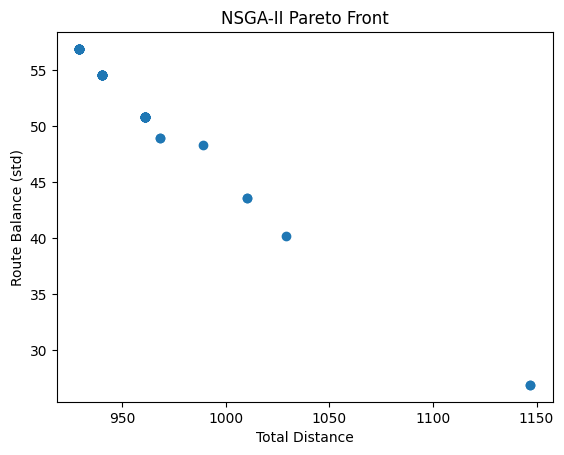

In [15]:
# NSGA-II main loop
def nsga2(dmat, N, V, pop_size=50, generations=50, pc=0.9, pm=0.2, seed=42):
    rng = random.Random(seed)
    pop = init_population(N,V,dmat,pop_size)
    objectives = [(total_distance(ind,dmat,V), objective_balance_std(ind,dmat,V)) for ind in pop]

    for gen in range(generations):
        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = rng.sample(pop,2)
            if rng.random() < pc:
                child_perm1, child_perm2 = order_crossover(p1.perm,p2.perm,rng)
                child_cuts1, child_cuts2 = cuts_crossover(p1.cuts,p2.cuts,N,V,rng)
            else:
                child_perm1, child_perm2 = p1.perm[:], p2.perm[:]
                child_cuts1, child_cuts2 = p1.cuts[:], p2.cuts[:]
            child_perm1 = swap_mutation_perm(child_perm1,rng,pm)
            child_perm2 = swap_mutation_perm(child_perm2,rng,pm)
            child_cuts1 = jitter_mutation_cuts(child_cuts1,N,V,rng,pm)
            child_cuts2 = jitter_mutation_cuts(child_cuts2,N,V,rng,pm)
            offspring.append(Individual(child_perm1,child_cuts1))
            offspring.append(Individual(child_perm2,child_cuts2))

        combined_pop = pop + offspring
        combined_obj = [(total_distance(ind,dmat,V), objective_balance_std(ind,dmat,V)) for ind in combined_pop]
        fronts = fast_non_dominated_sort(combined_obj)

        new_pop = []
        for front in fronts:
            if len(new_pop)+len(front) <= pop_size:
                new_pop.extend([combined_pop[i] for i in front])
            else:
                cd = crowding_distance(front, combined_obj)
                sorted_front = [x for _,x in sorted(zip(cd,front), reverse=True)]
                remaining = pop_size-len(new_pop)
                new_pop.extend([combined_pop[i] for i in sorted_front[:remaining]])
                break
        pop = new_pop
        objectives = [(total_distance(ind,dmat,V), objective_balance_std(ind,dmat,V)) for ind in pop]

    return pop, objectives

pop, objectives = nsga2(dmat,N,V,pop_size=50,generations=50)
f1_vals, f2_vals = zip(*objectives)

plt.scatter(f1_vals,f2_vals)
plt.xlabel("Total Distance")
plt.ylabel("Route Balance (std)")
plt.title("NSGA-II Pareto Front")
plt.show()

In [16]:
# Calculating the best individual 

best_idx = min(range(len(objectives)), key=lambda i: objectives[i][0])
best_ind = pop[best_idx]
print("Best total distance:", objectives[best_idx][0])
print("Best individual perm:", best_ind.perm)
print("Best individual cuts:", best_ind.cuts)


Best total distance: 929.2301653845227
Best individual perm: [25, 38, 47, 39, 44, 49, 31, 20, 15, 19, 8, 28, 3, 11, 16, 33, 50, 42, 17, 32, 41, 43, 26, 12, 2, 40, 35, 22, 30, 48, 18, 9, 6, 46, 29, 36, 27, 37, 13, 4, 5, 34, 45, 14, 7, 23, 24, 1, 21, 10]
Best individual cuts: [11, 20, 30, 40]


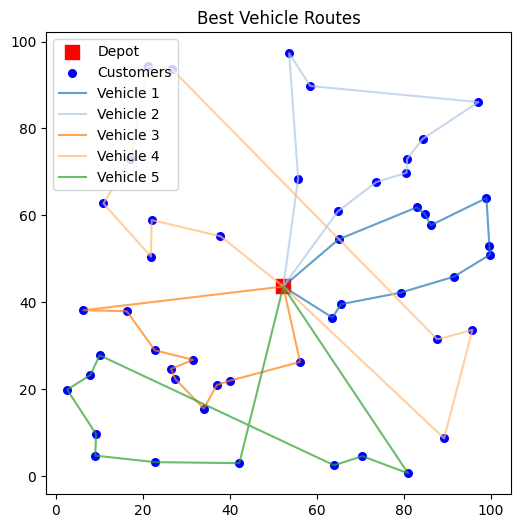

In [17]:
# Ploting the best routes 

def plot_routes(ind, depot, customer_coords, V):
    routes = decode_routes(ind,V)
    plt.figure(figsize=(6,6))
    plt.scatter(depot[0],depot[1],c='red',marker='s',s=100,label='Depot')
    x_cust = [c[0] for c in customer_coords]
    y_cust = [c[1] for c in customer_coords]
    plt.scatter(x_cust,y_cust,c='blue',s=30,label='Customers')
    colors = plt.cm.tab20.colors
    for i, route in enumerate(routes):
        if not route: continue
        coords = [depot]+[customer_coords[c-1] for c in route]+[depot]
        xs,ys = zip(*coords)
        plt.plot(xs,ys,'-',color=colors[i%len(colors)],alpha=0.7,label=f"Vehicle {i+1}")
    plt.legend()
    plt.title("Best Vehicle Routes")
    plt.show()

plot_routes(best_ind,depot,customer_coords,V)

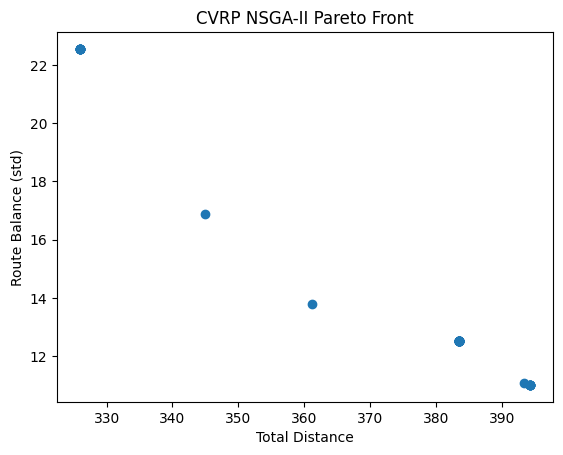

In [19]:
# Adding the deands now 

if "demand" not in customers.columns:
    np.random.seed(42)
    customers["demand"] = np.random.randint(1, 10, size=len(customers))
demands = customers["demand"].tolist()
Q = 15  


# Decoding the routes with the  capacity 

def decode_routes_cvrp(ind: Individual, V: int, demands: List[int], Q: int):
    perm = ind.perm
    routes = []
    route = []
    load = 0
    for customer in perm:
        if load + demands[customer-1] > Q:
            routes.append(route)
            route = []
            load = 0
        route.append(customer)
        load += demands[customer-1]
    if route:
        routes.append(route)
    while len(routes) < V:
        routes.append([])
    return routes[:V]

#CVRP objective functions
def total_distance_cvrp(ind: Individual, dmat, V, demands, Q):
    routes = decode_routes_cvrp(ind, V, demands, Q)
    return sum(route_distance(r, dmat) for r in routes)

def objective_balance_std_cvrp(ind: Individual, dmat, V, demands, Q):
    routes = decode_routes_cvrp(ind, V, demands, Q)
    lengths = [route_distance(r, dmat) for r in routes]
    return float(np.std(lengths))

# NSGA-II adapted for CVRP
def nsga2_cvrp(dmat, N, V, demands, Q, pop_size=50, generations=50, pc=0.9, pm=0.2, seed=42):
    rng = random.Random(seed)
    pop = init_population(N, V, dmat, pop_size)
    objectives = [(total_distance_cvrp(ind,dmat,V,demands,Q),
                   objective_balance_std_cvrp(ind,dmat,V,demands,Q)) for ind in pop]

    for gen in range(generations):
        offspring = []
        while len(offspring) < pop_size:
            if len(pop) < 2:
                raise ValueError("Population must have at least 2 individuals for crossover.")
            p1, p2 = rng.sample(pop, 2)
            if rng.random() < pc:
                child_perm1, child_perm2 = order_crossover(p1.perm,p2.perm,rng)
                child_cuts1, child_cuts2 = cuts_crossover(p1.cuts,p2.cuts,N,V,rng)
            else:
                child_perm1, child_perm2 = p1.perm[:], p2.perm[:]
                child_cuts1, child_cuts2 = p1.cuts[:], p2.cuts[:]
            child_perm1 = swap_mutation_perm(child_perm1,rng,pm)
            child_perm2 = swap_mutation_perm(child_perm2,rng,pm)
            child_cuts1 = jitter_mutation_cuts(child_cuts1,N,V,rng,pm)
            child_cuts2 = jitter_mutation_cuts(child_cuts2,N,V,rng,pm)
            offspring.append(Individual(child_perm1,child_cuts1))
            offspring.append(Individual(child_perm2,child_cuts2))

        combined_pop = pop + offspring
        combined_obj = [(total_distance_cvrp(ind,dmat,V,demands,Q),
                         objective_balance_std_cvrp(ind,dmat,V,demands,Q)) for ind in combined_pop]
        fronts = fast_non_dominated_sort(combined_obj)

        new_pop = []
        for front in fronts:
            if len(new_pop)+len(front) <= pop_size:
                new_pop.extend([combined_pop[i] for i in front])
            else:
                cd = crowding_distance(front, combined_obj)
                sorted_front = [x for _,x in sorted(zip(cd,front), reverse=True)]
                remaining = pop_size-len(new_pop)
                new_pop.extend([combined_pop[i] for i in sorted_front[:remaining]])
                break
        pop = new_pop
        objectives = [(total_distance_cvrp(ind,dmat,V,demands,Q),
                       objective_balance_std_cvrp(ind,dmat,V,demands,Q)) for ind in pop]

    return pop, objectives

# Run CVRP NSGA-II
pop_cvrp, objectives_cvrp = nsga2_cvrp(dmat, N, V, demands, Q, pop_size=50, generations=50)
f1_vals_cvrp, f2_vals_cvrp = zip(*objectives_cvrp)

# Pareto front plot for CVRP
plt.scatter(f1_vals_cvrp,f2_vals_cvrp)
plt.xlabel("Total Distance")
plt.ylabel("Route Balance (std)")
plt.title("CVRP NSGA-II Pareto Front")
plt.show()

In [20]:
# Best individual for CVRP
best_idx = min(range(len(objectives_cvrp)), key=lambda i: objectives_cvrp[i][0])
best_ind = pop_cvrp[best_idx]
print("Best total distance (CVRP):", objectives_cvrp[best_idx][0])
print("Best individual perm:", best_ind.perm)
print("Best individual cuts:", best_ind.cuts)

Best total distance (CVRP): 325.90405911888377
Best individual perm: [32, 38, 39, 44, 49, 8, 3, 11, 50, 22, 12, 25, 6, 19, 1, 36, 31, 24, 27, 35, 29, 40, 2, 30, 4, 33, 21, 5, 17, 47, 10, 41, 42, 20, 15, 18, 28, 45, 14, 46, 7, 26, 43, 9, 13, 23, 48, 37, 34, 16]
Best individual cuts: [15, 21, 38, 41]


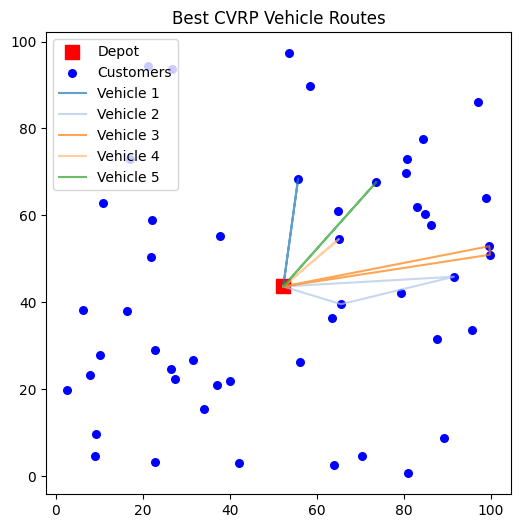

In [21]:
# Plot best CVRP routes
def plot_routes_cvrp(ind, depot, customer_coords, V, demands):
    routes = decode_routes_cvrp(ind,V,demands,Q)
    plt.figure(figsize=(6,6))
    plt.scatter(depot[0],depot[1],c='red',marker='s',s=100,label='Depot')
    x_cust = [c[0] for c in customer_coords]
    y_cust = [c[1] for c in customer_coords]
    plt.scatter(x_cust,y_cust,c='blue',s=30,label='Customers')
    colors = plt.cm.tab20.colors
    for i, route in enumerate(routes):
        if not route: continue
        coords = [depot]+[customer_coords[c-1] for c in route]+[depot]
        xs,ys = zip(*coords)
        plt.plot(xs,ys,'-',color=colors[i%len(colors)],alpha=0.7,label=f"Vehicle {i+1}")
    plt.legend()
    plt.title("Best CVRP Vehicle Routes")
    plt.show()

plot_routes_cvrp(best_ind,depot,customer_coords,V,demands)

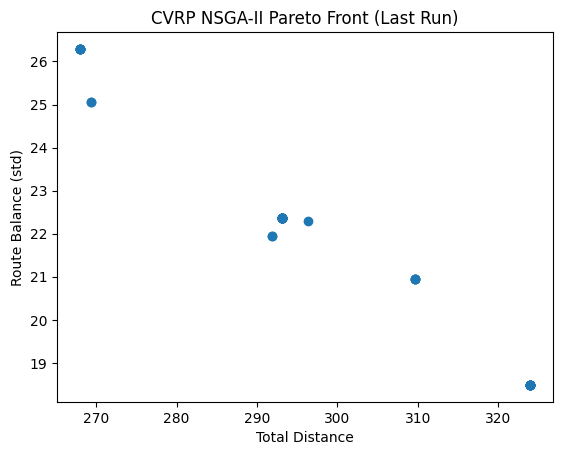

In [22]:
# Multiple runs 

all_objectives = []
runs = 5  # increase for more robustness
for seed in range(runs):
    pop_cvrp, objectives_cvrp = nsga2_cvrp(dmat, N, V, demands, Q, pop_size=50, generations=50, seed=seed)
    all_objectives.append(objectives_cvrp)

# Pareto front of last run 

f1_vals_cvrp, f2_vals_cvrp = zip(*objectives_cvrp)
plt.scatter(f1_vals_cvrp, f2_vals_cvrp)
plt.xlabel("Total Distance")
plt.ylabel("Route Balance (std)")
plt.title("CVRP NSGA-II Pareto Front (Last Run)")
plt.show()

In [23]:
# Best solution across the last run
best_idx = min(range(len(objectives_cvrp)), key=lambda i: objectives_cvrp[i][0])
best_ind = pop_cvrp[best_idx]
print("Best total distance (CVRP):", objectives_cvrp[best_idx][0])
print("Best individual perm:", best_ind.perm)
print("Best individual cuts:", best_ind.cuts)

Best total distance (CVRP): 267.9186024065051
Best individual perm: [38, 44, 49, 47, 8, 28, 40, 50, 4, 23, 43, 26, 21, 19, 42, 16, 15, 3, 37, 9, 24, 2, 20, 39, 7, 25, 36, 41, 10, 35, 33, 34, 22, 30, 14, 29, 6, 17, 12, 11, 27, 5, 45, 31, 18, 32, 46, 13, 48, 1]
Best individual cuts: [8, 24, 31, 40]


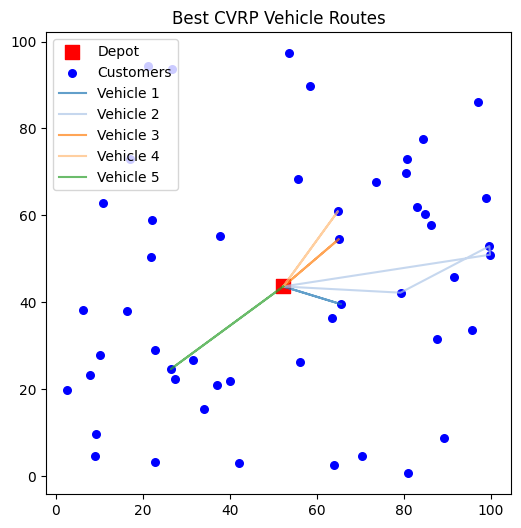

Best solution saved to 'best_cvrp_solution.csv'.


In [24]:
# Plot best CVRP routes
plot_routes_cvrp(best_ind, depot, customer_coords, V, demands)

# Saving the best solution 
solution_df = pd.DataFrame({
    "perm": [best_ind.perm],
    "cuts": [best_ind.cuts],
    "total_distance": [objectives_cvrp[best_idx][0]],
    "balance_std": [objectives_cvrp[best_idx][1]]
})
solution_df.to_csv("best_cvrp_solution.csv", index=False)
print("Best solution saved to 'best_cvrp_solution.csv'.")

In [25]:
# Analizing the average total distance and balance std over multiple runs
avg_total_distances = [min(obj, key=lambda x: x[0])[0] for obj in all_objectives]
avg_balance_std = [min(obj, key=lambda x: x[0])[1] for obj in all_objectives]
print("Average best total distance over runs:", np.mean(avg_total_distances))
print("Average best balance std over runs:", np.mean(avg_balance_std))

Average best total distance over runs: 283.02850190014135
Average best balance std over runs: 18.753567694619733


In [29]:
# Analizing multiple runss 
runs = 5  
pop_size = 50
generations = 50

all_objectives = []
best_solutions = []

for seed in range(runs):
    pop_cvrp, objectives_cvrp = nsga2_cvrp(dmat, N, V, demands, Q,
                                           pop_size=pop_size,
                                           generations=generations,
                                           seed=seed)
    all_objectives.append(objectives_cvrp)
    
    # Store best solution by total distance for this run
    best_idx = min(range(len(objectives_cvrp)), key=lambda i: objectives_cvrp[i][0])
    best_solutions.append((pop_cvrp[best_idx], objectives_cvrp[best_idx]))

avg_total_distance = np.mean([obj[0] for run in all_objectives for obj in run])
avg_balance_std = np.mean([obj[1] for run in all_objectives for obj in run])

min_total_distance = min([obj[0] for run in all_objectives for obj in run])
min_balance_std = min([obj[1] for run in all_objectives for obj in run])

print(f"Average total distance over all runs: {avg_total_distance:.2f}")
print(f"Average route balance (std) over all runs: {avg_balance_std:.2f}")
print(f"Minimum total distance found: {min_total_distance:.2f}")
print(f"Minimum route balance (std) found: {min_balance_std:.2f}")

Average total distance over all runs: 305.03
Average route balance (std) over all runs: 15.60
Minimum total distance found: 232.23
Minimum route balance (std) found: 7.94


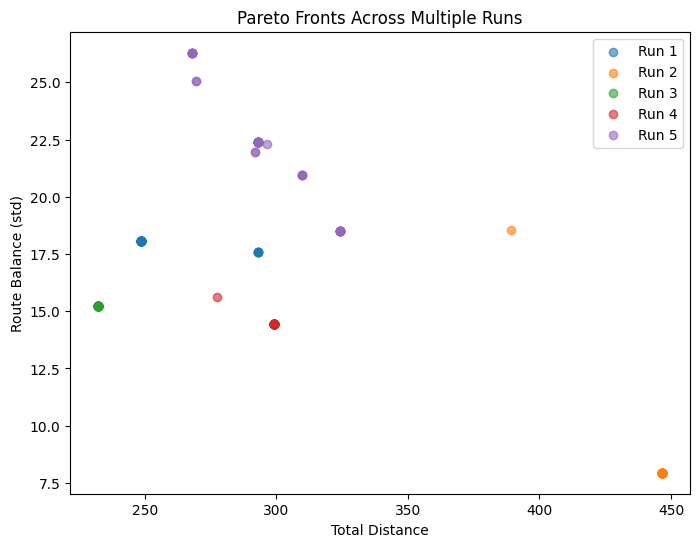

In [30]:
# Ploting 

plt.figure(figsize=(8,6))
for i, run_objs in enumerate(all_objectives):
    f1, f2 = zip(*run_objs)
    plt.scatter(f1, f2, alpha=0.6, label=f'Run {i+1}')
plt.xlabel("Total Distance")
plt.ylabel("Route Balance (std)")
plt.title("Pareto Fronts Across Multiple Runs")
plt.legend()
plt.show()

  1   |        248.45        |    18.07    


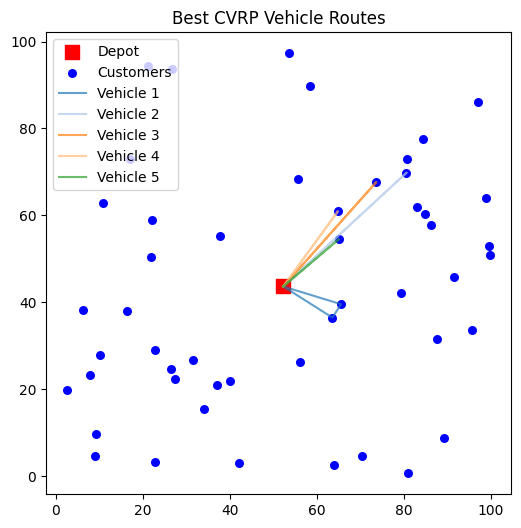

  2   |        389.28        |    18.55    


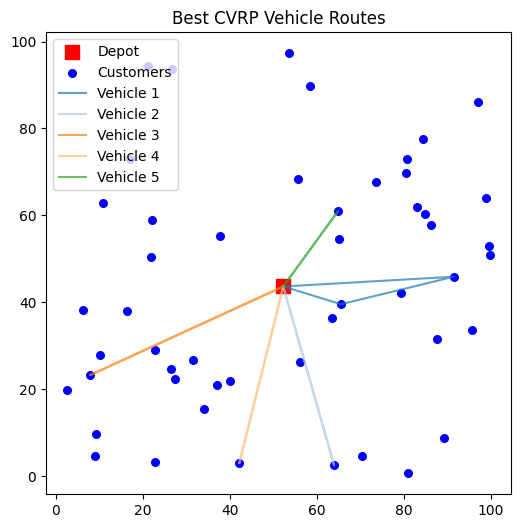

  3   |        232.23        |    15.24    


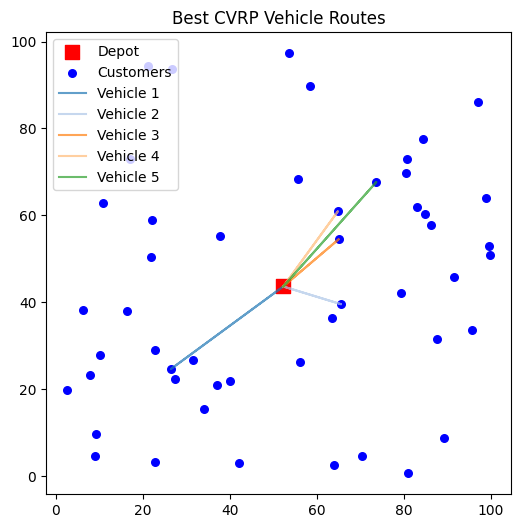

  4   |        277.27        |    15.62    


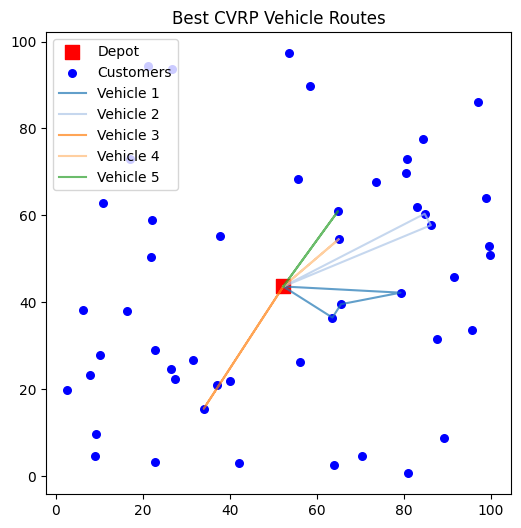

  5   |        267.92        |    26.29    


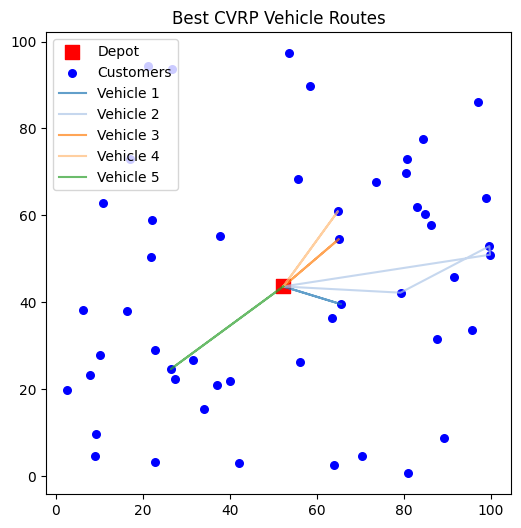

In [32]:
for i, (best_ind, best_obj) in enumerate(best_solutions):
    print(f"{i+1:^5} | {best_obj[0]:^20.2f} | {best_obj[1]:^12.2f}")
    plot_routes_cvrp(best_ind, depot, customer_coords, V, demands)


In [34]:
# Sumarizing the best solutions per run 

summary_data = []

for i, (best_ind, best_obj) in enumerate(best_solutions):
    routes = decode_routes_cvrp(best_ind, V, demands, Q)
    vehicles_used = sum(1 for r in routes if r)  # count non-empty routes
    summary_data.append({
        "Run": i+1,
        "Total Distance": round(best_obj[0], 2),
        "Route Balance (std)": round(best_obj[1], 2),
        "Vehicles Used": vehicles_used
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Optional: save to CSV for report
summary_df.to_csv("cvrp_nsga2_summary.csv", index=False)

   Run  Total Distance  Route Balance (std)  Vehicles Used
0    1          248.45                18.07              5
1    2          389.28                18.55              5
2    3          232.23                15.24              5
3    4          277.27                15.62              5
4    5          267.92                26.29              5


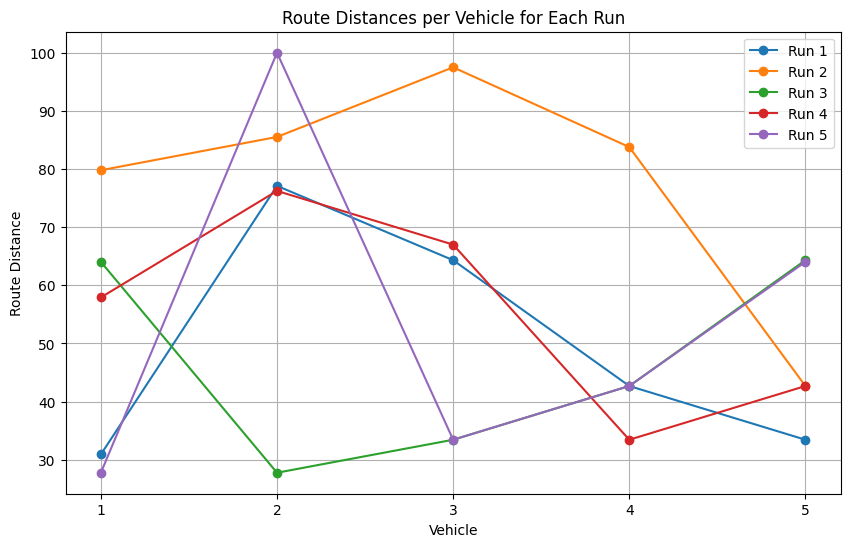

In [35]:
#Plot route distances per vehicle for each run
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for i, (best_ind, best_obj) in enumerate(best_solutions):
    routes = decode_routes_cvrp(best_ind, V, demands, Q)
    route_dists = [route_distance(r, dmat) if r else 0 for r in routes]
    plt.plot(range(1, V+1), route_dists, marker='o', label=f"Run {i+1}")

plt.xlabel("Vehicle")
plt.ylabel("Route Distance")
plt.title("Route Distances per Vehicle for Each Run")
plt.xticks(range(1, V+1))
plt.legend()
plt.grid(True)
plt.show()
